In [8]:
import os, sys

sys.path.append(os.path.join(os.getcwd(), "GroundingDINO"))

# If you have multiple GPUs, you can set the GPU to use here.
# The default is to use the first GPU, which is usually GPU 0.
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import argparse
import os
import copy
from glob import glob

import numpy as np
import torch
from PIL import Image, ImageDraw, ImageFont
from torchvision.ops import box_convert

# Grounding DINO
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from GroundingDINO.groundingdino.util.inference import annotate, load_image, predict


# segment anything
from segment_anything import build_sam, SamPredictor 
import cv2
import numpy as np
import matplotlib.pyplot as plt


# diffusers
import PIL
import requests
import torch
from io import BytesIO

from huggingface_hub import hf_hub_download

Load Grounding DINO model

In [2]:
def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file) 
    model = build_model(args)
    args.device = device

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location='cpu')
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model   

In [3]:
# Use this command for evaluate the Grounding DINO model
# Or you can download the model by yourself
ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"

In [4]:
groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename)

/home/shirakawa/miniconda3/envs/G_SAM/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded from /home/shirakawa/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight'])


Load SAM model

In [5]:
sam_checkpoint = '../segment-anything/test_SAM/sam_vit_h_4b8939.pth'
device ='cpu'
sam = build_sam(checkpoint=sam_checkpoint)
sam.to(device=device)
sam_predictor = SamPredictor(sam)

Load demo image

In [13]:
# image path
data_name = "rosbag2_2023_03_03-14_28_12_10"
camera_name = 'c2'
image_paths = sorted(glob(f'../../data/odaiba_data/results/{data_name}/{camera_name}/image_raw/compressed/*.png'))

In [16]:
local_image_path = image_paths[0]

In [59]:
TEXT_PROMPT = "dog"#"bench", "dog"]
TEXT_PROMPTs = ["car", "traffic light","bus","human", "sign", "red light"]
BOX_TRESHOLD = 0.3
TEXT_TRESHOLD = 0.25

image_source, image = load_image(local_image_path)

In [60]:
def show_mask_as_set_color(mask, image,Color):
    
    color = np.array([Color.b/255, Color.g/255, Color.r/255, 0.8])#np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    
    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))

In [61]:
from supervision.draw.color import Color, ColorPalette
self_color= ColorPalette.default()

In [62]:
masks[0][1]

IndexError: index 1 is out of bounds for dimension 0 with size 1

In [67]:
image_base = image_source
# set image
sam_predictor.set_image(image_source)
idx = 0
for i, TEXT_PROMPT in enumerate(TEXT_PROMPTs):
    
    boxes, logits, phrases = predict(
        model=groundingdino_model, 
        image=image, 
        caption=TEXT_PROMPT, 
        box_threshold=BOX_TRESHOLD, 
        text_threshold=TEXT_TRESHOLD, device='cpu'
    )

    annotated_frame = annotate(image_source=image_base, boxes=boxes, logits=logits, phrases=phrases)
    annotated_frame = annotated_frame
    
    
    # box: normalized box xywh -> unnormalized xyxy
    H, W, _ = image_source.shape
    boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])
    
    transformed_boxes = sam_predictor.transform.apply_boxes_torch(boxes_xyxy, image_source.shape[:2]).to(device)
    if len(transformed_boxes) > 0:
        masks, _, _ = sam_predictor.predict_torch(
                    point_coords = None,
                    point_labels = None,
                    boxes = transformed_boxes,
                    multimask_output = False,
                )
        print(len(masks))
        for j in range(len(masks)):
            annotated_frame =  show_mask_as_set_color(masks[j][0], annotated_frame,self_color.colors[idx] )
        annotated_frame_with_mask = annotated_frame
        idx = idx + i+1#idx + len(boxes) +1
        #annotated_frame_with_mask = show_mask(masks[0][0], annotated_frame)
        image_base = annotated_frame_with_mask
annotated_frame = image_base # BGR to RGB

5
3
2
1
1


In [65]:
transformed_boxes

tensor([], size=(0, 4))

In [ ]:
image_source

In [70]:
ann = Image.fromarray(annotated_frame[...,[2,1,0,3]])

In [71]:
so = Image.fromarray(image_source)

In [75]:
def get_concat_v(im1, im2):
    dst = Image.new('RGB', (im1.width, im1.height + im2.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    return dst

def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

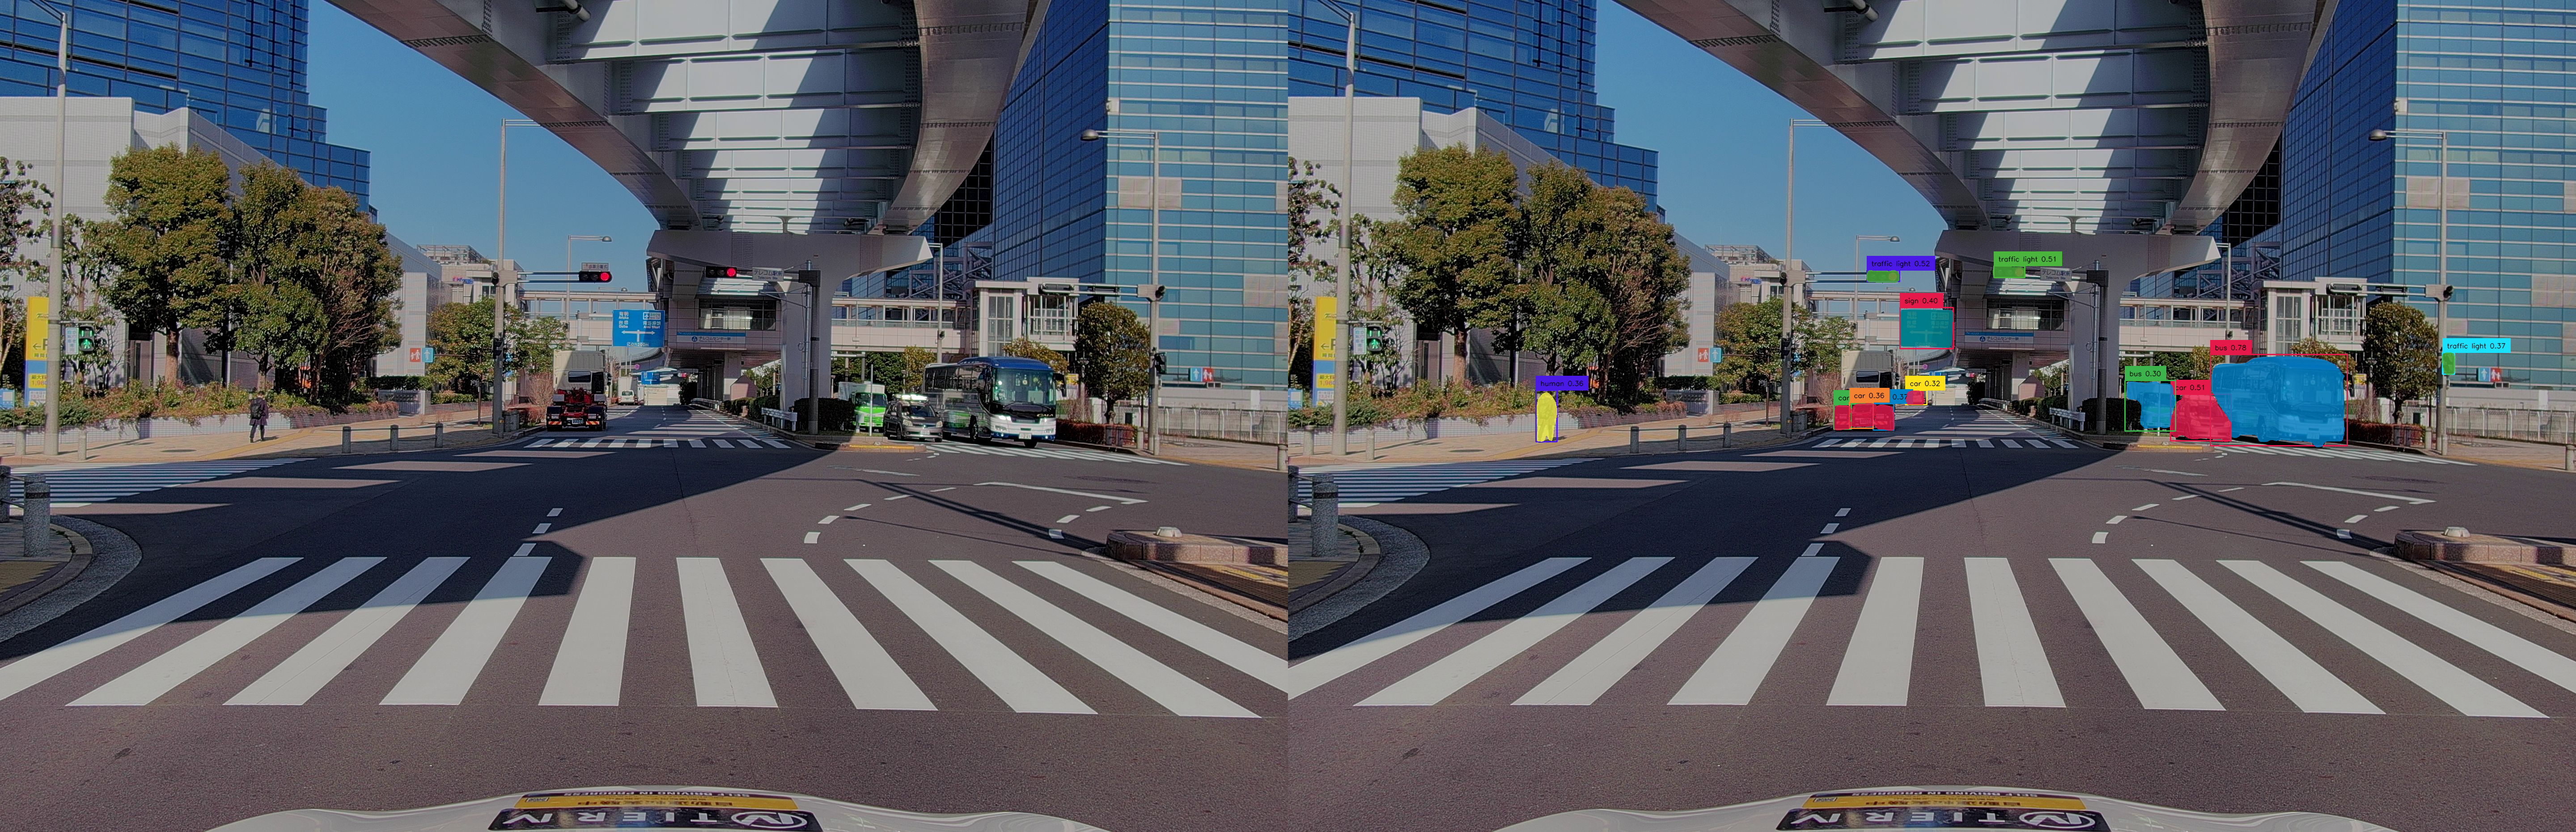

In [76]:
get_concat_h(so, ann)